## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

import sys
sys.path.append('/home/jcollins')

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params, \
                                              jack_1_template
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [4]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae_bneck-1'
n_pc_points = 1000                # Number of points per model.
bneck_size = 1                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

Load Point-Clouds

In [5]:
import pandas as pd
numjets = 500000
numvalid = 50000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points.h5")
# rawdata = outstore.select("points",stop=numjets).values
# rawdata = rawdata.reshape(numjets,1000,2)
# all_pc_data = PointCloudDataSet(rawdata,copy=False)
validdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
validdata = validdata.reshape(numvalid,1000,2)
valid_pc_data = PointCloudDataSet(validdata,copy=False)
gc.collect()

28

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [6]:
train_params = default_train_params()
train_params['saver_step'] = 2

In [7]:
encoder, decoder, enc_args, dec_args = jack_1_template(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [8]:
conf = Conf(n_input = [n_pc_points, 2],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 1   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

In [33]:
load_pre_trained_ae = True
restore_epoch = 4
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
encoder_conv_layer_0 conv params =  384 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_1 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Symmetry Layer:
Tensor("single_class_ae_bneck-1_2/Sum:0", shape=(?, 128), dtype=float32) 

encoder_dense_layer_0 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_2:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_1 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_3:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_2 FC params =  129 bnorm params =  2
Tensor("single_class_ae_bneck-1_2/encoder_dense_layer_2_bnorm/batchnorm/add_1:0", shape=(?, 1), dtype=float32)
output size: 1 

Building Decoder
decoder_fc_0 FC params =  512 Tensor("single_class

Get a batch of reconstuctions and their latent-codes.

Use any plotting mechanism such as matplotlib to visualize the results.

In [34]:
import ot
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

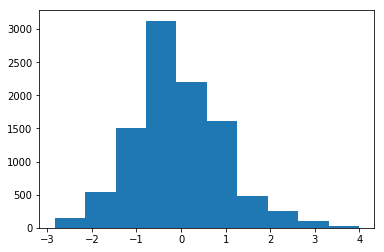

In [35]:
numload = 1000
latent_codes = np.zeros((0,1))
for i in range(10):
    feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
    latent_codes = np.append(latent_codes,ae.transform(feed_pc),axis=0)


plt.hist(latent_codes[:,0])
plt.show()

In [36]:
latent_codes[:,0]

array([-1.32890534, -0.77772063,  1.58132505, ...,  0.01490247,
       -0.77738005, -0.02759123])

In [37]:
numload = 1000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

In [38]:
def jet_masses(jets, p_norm = 600):
    numpoints = len(jets[0])
    Delta_Rs = np.linalg.norm(feed_pc,axis=2)
#    p_parr = np.sum(np.cos(Delta_Rs),axis=1)
    p_parr = np.sum(np.cos(jets[:,:,0])*np.cos(jets[:,:,1]),axis=1)
    masses = np.sqrt(numpoints**2 - np.power(p_parr,2))*p_norm/numpoints
    return masses

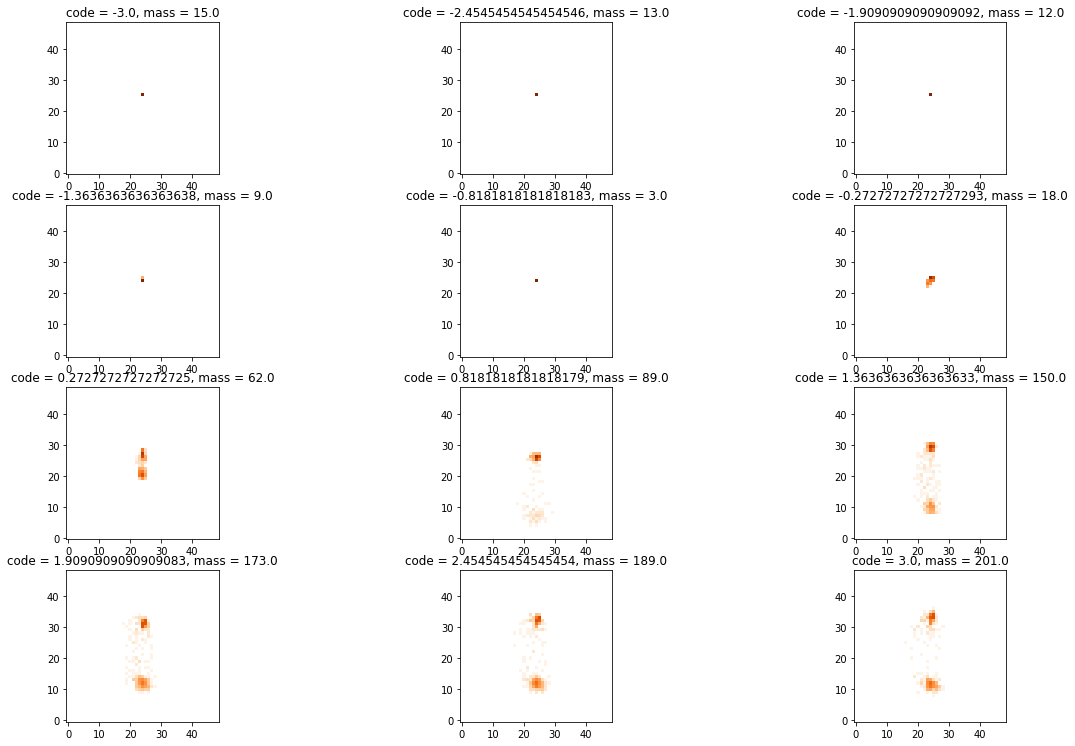

In [39]:
lim=0.8
bins=np.linspace(-lim, lim, 50)
#codes = np.array([0.45,0.7,1])
codes = np.linspace(-3,3,12)
temp_reconstructions=ae.decode(codes.reshape(-1,1))

plt.figure(figsize=[20,80])

jet_ms = jet_masses(temp_reconstructions)

for i, reconstruction in enumerate(temp_reconstructions):
    plt.subplot(24,3,i+1)
    counts, bx, by = np.histogram2d(reconstruction[:,0],reconstruction[:,1],bins=bins)
    #print codes[i]
    plt.imshow(counts.T, norm=LogNorm(0.9, 1000), origin='lower',cmap='Oranges')
    plt.title("code = " + str(codes[i]) +  ", mass = " + str(round(jet_ms[i])))
plt.show()

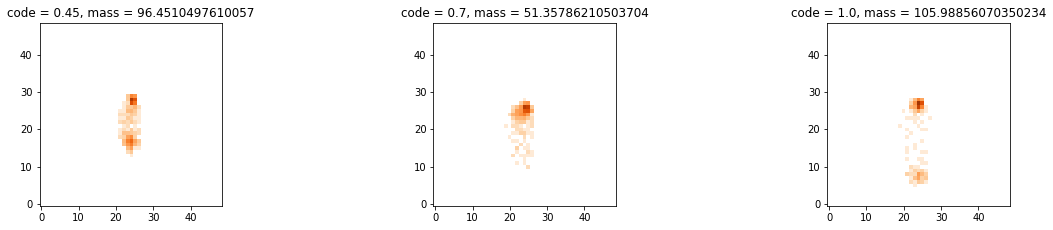

In [40]:
lim=0.8
bins=np.linspace(-lim, lim, 50)
codes = np.array([0.45,0.7,1])
#codes = np.arange(0.4,1.5,0.05)
temp_reconstructions=ae.decode(codes.reshape(-1,1))

plt.figure(figsize=[20,80])

jet_ms = jet_masses(temp_reconstructions)

for i, reconstruction in enumerate(temp_reconstructions):
    plt.subplot(20,3,i+1)
    counts, bx, by = np.histogram2d(reconstruction[:,0],reconstruction[:,1],bins=bins)
    #print codes[i]
    plt.imshow(counts.T, norm=LogNorm(0.5, 1000), origin='lower',cmap='Oranges')
    plt.title("code = " + str(codes[i]) +  ", mass = " + str(jet_ms[i]))
plt.show()

In [41]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch


print "##### Approx EMD #####"
nclouds = 1
npoints = 1000
ndim=2

points1 = reconstructions[:10]
points2 = feed_pc[:10]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = sess.run(this_cost)/1000*600
    print np.array(cost)
    
print time.time()-start


print "\n \n \n ##### True EMD #####"
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print time.time()-start
print truecost

print "\n \n \n ##### Fractional difference #####"
print (np.array(cost) - np.array(truecost))/np.array(truecost)

##### Approx EMD #####
[57.65053  57.73678  35.23678  25.937376 14.544908 82.961716 34.307213
 40.90417  10.923782 15.150064]
3.42169594765

 
 
 ##### True EMD #####
1.5618519783
[53.8935175  55.78583938 34.89192267 25.63122863 14.22414301 72.73093012
 33.2270086  33.58494072 10.65109268 14.75864456]

 
 
 ##### Fractional difference #####
[0.0697118  0.03497194 0.00988354 0.01194431 0.02255071 0.14066623
 0.03250982 0.21793191 0.02560204 0.0265214 ]


44.9112645806


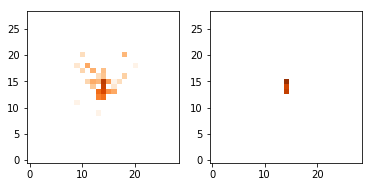

46.4881994843


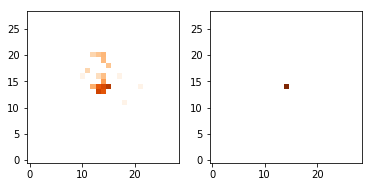

29.0766022277


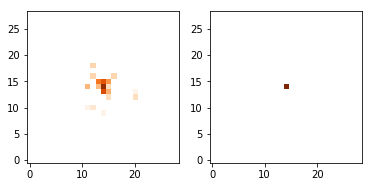

21.3593571947


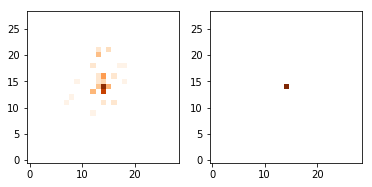

11.8534525045


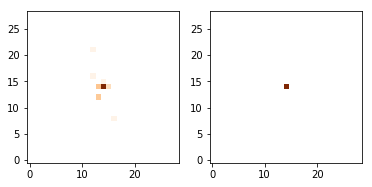

60.6091084329


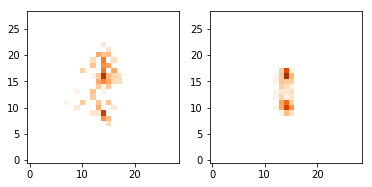

27.6891738327


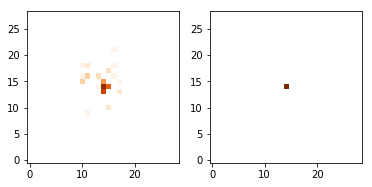

27.9874506011


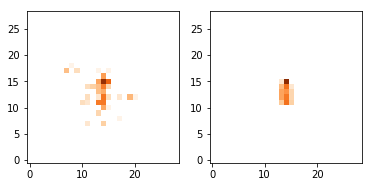

8.87591056446


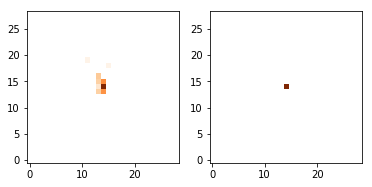

12.2988704647


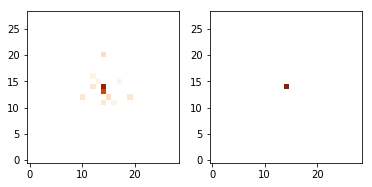

In [42]:
countcut=0.9
lim=1.5
bins=np.linspace(-lim, lim, 30)

#for i in range(len(feed_pc)):
for i in range(10):   

    M = np.sqrt(ot.dist(feed_pc[i],reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)/1000*500

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[6,3])
    counts, bx, by = np.histogram2d(feed_pc[i][:,0],feed_pc[i][:,1],bins=bins)
    ax[0].imshow(counts.T , norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(reconstructions[i][:,0],reconstructions[i][:,1],bins=bins)
    ax[1].imshow(counts.T, norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [24]:
import time
points1 = reconstructions[:100]
points2 = feed_pc[:100]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

qcd_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print qcd_truecost
print time.time()-start

print np.average(qcd_truecost)
print np.std(qcd_truecost)

[ 61.11268449  30.87777507  31.3446951   20.79172709  43.58828969
  39.48794812  58.85911939  23.85980928  37.26742307  58.66658412
  21.55742592  88.18804373  67.80691213  33.07713228  46.13786782
  24.26975323  13.28510166  64.75777112  50.21288408  82.23240176
  21.09713557  47.86646606  33.7106537   32.6959184   42.67315385
  18.76091635  25.85779245  35.75304524  47.27786108  54.3533986
  49.36054239  48.77559453  31.27744182   7.32071313  15.02341253
  43.98301108  37.18116652  37.80741002  56.00492543  23.63654126
  30.35584172 127.58252533  11.8074895   23.01705018  20.85282104
  45.99004138  56.29942735  16.44129127  33.6518503   45.43706884
  42.66510122  22.98995081  77.51584313  29.70242362 102.77107543
  20.28178286  21.87856379  20.83178391  57.70706594  49.677128
  64.8110381   31.90783932  26.41838376  16.94177314  28.10347482
  35.51774485  33.48118394  58.50895984  51.02674911  11.63433569
  43.65710914  28.95658259  20.50621649  98.41160957  34.72995644
  27.99871845

In [25]:
import pandas as pd
numjets = 0
numvalid = 10000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top.h5")
topdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
topdata = topdata.reshape(numvalid,1000,2)
top_pc_data = PointCloudDataSet(topdata,copy=False)
gc.collect()


numload = 1000
top_feed_pc, feed_model_names, _ = top_pc_data.next_batch(numload )
top_reconstructions = ae.reconstruct(top_feed_pc)[0]
top_latent_codes = ae.transform(top_feed_pc)

59.2136573898


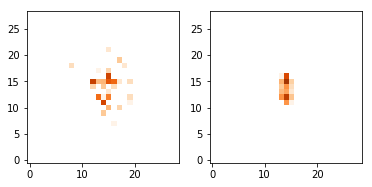

101.86522459


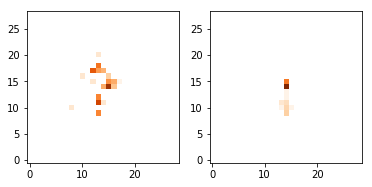

52.6885473283


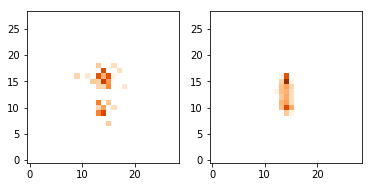

56.2608547642


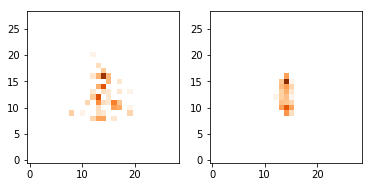

96.0889276976


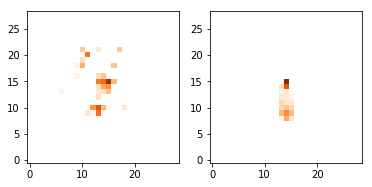

85.2488629205


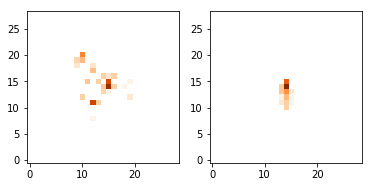

98.8402074546


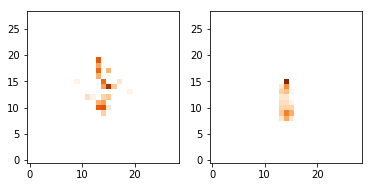

64.2982128306


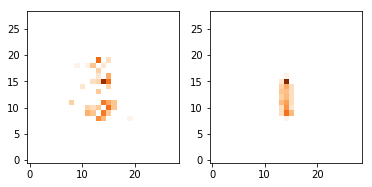

68.9342488338


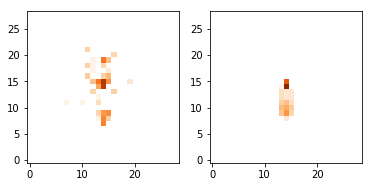

73.2739120924


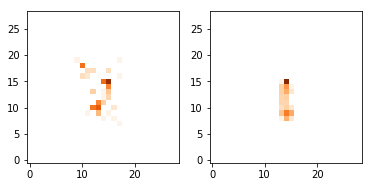

In [26]:
countcut=0.9
lim=1.5
bins=np.linspace(-lim, lim, 30)

#for i in range(len(feed_pc)):
for i in range(10):   

    M = np.sqrt(ot.dist(top_feed_pc[i],top_reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)/1000*500

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[6,3])
    counts, bx, by = np.histogram2d(top_feed_pc[i][:,0],top_feed_pc[i][:,1],bins=bins)
    ax[0].imshow(counts.T , norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(top_reconstructions[i][:,0],top_reconstructions[i][:,1],bins=bins)
    ax[1].imshow(counts.T, norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [27]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch


print "##### Approx EMD #####"
nclouds = 1
npoints = 1000
ndim=2

points1 = top_reconstructions[:10]
points2 = top_feed_pc[:10]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = sess.run(this_cost)/1000*600
    print np.array(cost)
    
print time.time()-start


print "\n \n \n ##### True EMD #####"
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print time.time()-start
print truecost

print "\n \n \n ##### Fractional difference #####"
print (np.array(cost) - np.array(truecost))/np.array(truecost)

##### Approx EMD #####
[ 76.33682  127.425125  74.77491   77.75064  119.586266 109.98129
 123.89398   84.9479    89.47136   93.142   ]
3.51504421234

 
 
 ##### True EMD #####
1.65606713295
[ 71.05638887 122.23826951  63.22625679  67.51302572 115.30671324
 102.2986355  118.60824895  77.1578554   82.7210986   87.92869451]

 
 
 ##### Fractional difference #####
[0.07431328 0.04243234 0.18265597 0.15163911 0.03711451 0.07510029
 0.04456463 0.10096242 0.08160265 0.05929013]


In [28]:
import time
points1 = reconstructions[:1000]
points2 = feed_pc[:1000]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

qcd_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print qcd_truecost
print time.time()-start

print np.average(qcd_truecost)
print np.std(qcd_truecost)

import time
points1 = top_reconstructions[:1000]
points2 = top_feed_pc[:1000]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

top_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print top_truecost
print time.time()-start

print np.average(top_truecost)
print np.std(top_truecost)

[ 61.11268449  30.87777507  31.3446951   20.79172709  43.58828969
  39.48794812  58.85911939  23.85980928  37.26742307  58.66658412
  21.55742592  88.18804373  67.80691213  33.07713228  46.13786782
  24.26975323  13.28510166  64.75777112  50.21288408  82.23240176
  21.09713557  47.86646606  33.7106537   32.6959184   42.67315385
  18.76091635  25.85779245  35.75304524  47.27786108  54.3533986
  49.36054239  48.77559453  31.27744182   7.32071313  15.02341253
  43.98301108  37.18116652  37.80741002  56.00492543  23.63654126
  30.35584172 127.58252533  11.8074895   23.01705018  20.85282104
  45.99004138  56.29942735  16.44129127  33.6518503   45.43706884
  42.66510122  22.98995081  77.51584313  29.70242362 102.77107543
  20.28178286  21.87856379  20.83178391  57.70706594  49.677128
  64.8110381   31.90783932  26.41838376  16.94177314  28.10347482
  35.51774485  33.48118394  58.50895984  51.02674911  11.63433569
  43.65710914  28.95658259  20.50621649  98.41160957  34.72995644
  27.99871845

[ 71.05638887 122.23826951  63.22625679  67.51302572 115.30671324
 102.2986355  118.60824895  77.1578554   82.7210986   87.92869451
  65.98922386  81.67573544  98.99805977  91.18991455  83.65823533
 153.92881207  67.85532751  98.53142663 135.38158898 109.36972971
  70.00934764  79.61623985  77.05998452 137.64495032  58.77381483
  48.71777011  91.26206743 133.90431267  92.86466329  84.55834326
  83.98589023  93.97460993  66.15752063  99.23850951  75.2366637
  62.85227055 113.87571702 101.78285019 118.99506915  78.49427504
 115.62512756  69.55786543 122.36344619  54.92206231  92.59596826
 115.73800722 113.60903988  83.70383959  50.43067339  82.99855817
  67.88467382  47.05566723  66.18990336  98.58129623  76.14992251
  88.00825423  74.5851783   72.63247549  63.87128597 111.76660287
  95.86795446  82.72757261  92.05723263  66.78851827  73.84628974
  84.63725964  73.21760534  70.38211531 142.26588404  93.38622504
  51.42735831  80.33598409 126.8944442   88.10962278 113.5624997
  91.7941650

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:2508: RuntimeWarning: overflow encountered in double_scalars
  x1t += delta


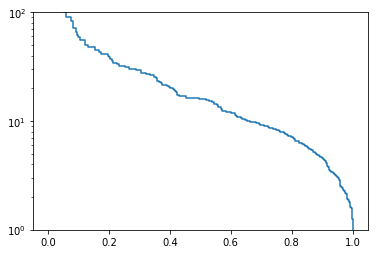

In [41]:
from sklearn.metrics import roc_curve

y_true = np.append(np.zeros(len(qcd_truecost)),np.ones(len(top_truecost)))
y_score = np.append(qcd_truecost, top_truecost)
my_roc = roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

plt.plot(my_roc[1],np.nan_to_num(1/my_roc[0]))
plt.ylim([1,10**2])
plt.semilogy()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.


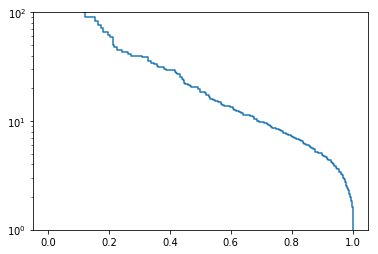

In [110]:



from sklearn.metrics import roc_curve

y_true = np.append(np.zeros(len(qcd_truecost)),np.ones(len(top_truecost)))
y_score = np.append(qcd_truecost, top_truecost)
my_roc = roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

plt.plot(my_roc[1],np.nan_to_num(1/my_roc[0]))
plt.ylim([1,10**2])
plt.semilogy()
plt.show()

In [96]:
np.nan_to_num(1/my_roc[0])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


array([1.79769313e+308, 1.79769313e+308, 1.00000000e+002, 1.00000000e+002,
       5.00000000e+001, 5.00000000e+001, 3.33333333e+001, 3.33333333e+001,
       2.00000000e+001, 2.00000000e+001, 1.66666667e+001, 1.66666667e+001,
       1.42857143e+001, 1.42857143e+001, 1.25000000e+001, 1.25000000e+001,
       1.00000000e+001, 1.00000000e+001, 9.09090909e+000, 9.09090909e+000,
       8.33333333e+000, 8.33333333e+000, 7.69230769e+000, 7.69230769e+000,
       7.14285714e+000, 7.14285714e+000, 6.66666667e+000, 6.66666667e+000,
       5.88235294e+000, 5.88235294e+000, 5.55555556e+000, 5.55555556e+000,
       5.26315789e+000, 5.26315789e+000, 4.54545455e+000, 4.54545455e+000,
       3.84615385e+000, 3.84615385e+000, 3.57142857e+000, 3.57142857e+000,
       2.85714286e+000, 2.85714286e+000, 1.00000000e+000])

In [29]:
import time
numload = 1000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)
points1 = reconstructions[:1000]
#points1 = feed_pc[:1000]
latent_codes = ae.transform(feed_pc[:1000])

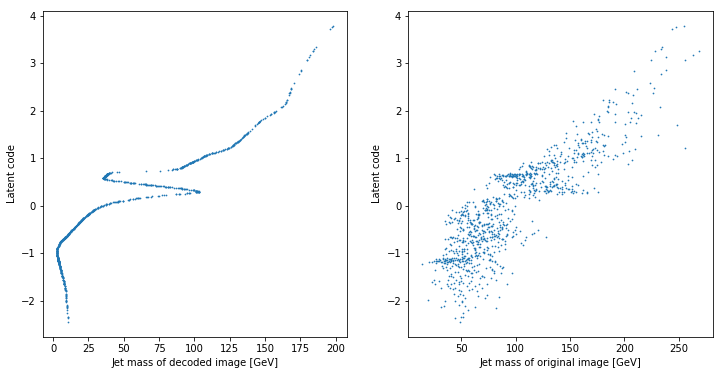

In [30]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.scatter(jet_masses(reconstructions[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of decoded image [GeV]')
plt.ylabel('Latent code')
plt.subplot(1,2,2)
plt.scatter(jet_masses(feed_pc[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of original image [GeV]')
plt.ylabel('Latent code')
plt.show()

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(jet_masses(reconstructions[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of decoded image [GeV]')
plt.ylabel('Latent code')
plt.show()

In [63]:
latent_codes

array([[0.00000000e+00],
       [0.00000000e+00],
       [5.81276476e-01],
       [1.26240134e+00],
       [3.47610474e-01],
       [1.75073600e+00],
       [1.39840186e-01],
       [1.92238939e+00],
       [3.10518295e-01],
       [1.17008245e+00],
       [3.96468550e-01],
       [7.54160583e-02],
       [4.76377696e-01],
       [0.00000000e+00],
       [2.68678188e-01],
       [6.89374804e-01],
       [0.00000000e+00],
       [8.80986333e-01],
       [0.00000000e+00],
       [1.44568950e-01],
       [2.33953893e-01],
       [3.62116545e-01],
       [0.00000000e+00],
       [7.80828893e-02],
       [1.66362613e-01],
       [2.27818418e+00],
       [2.96546161e-01],
       [0.00000000e+00],
       [2.14791155e+00],
       [9.05103624e-01],
       [0.00000000e+00],
       [1.44773412e+00],
       [1.10544348e+00],
       [6.39003396e-01],
       [2.02482671e-01],
       [0.00000000e+00],
       [8.25659990e-01],
       [7.49899149e-01],
       [8.32780004e-01],
       [1.34153813e-01],


In [74]:
numload = 10000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
feed_pc[0]

array([[ 0.017118  ,  0.19660918],
       [ 0.017118  ,  0.19660918],
       [ 0.017118  ,  0.19660918],
       ...,
       [-0.3880499 , -0.32016189],
       [ 0.01924656,  0.57144681],
       [ 0.63545814,  0.64884996]])

In [69]:
numpoints = len(jets[0])
Delta_Rs = np.linalg.norm(feed_pc,axis=2)
#    p_parr = np.sum(np.cos(Delta_Rs),axis=1)
np.sum(np.sin(jets[:,:,1]),axis=1)*600/1000

array([ 1.04154646, -1.01855432,  0.82381232,  2.8626084 ,  4.66926383,
        0.44145631, -0.78976928,  0.42520581, -0.56581046,  7.00944821,
       -0.0294308 , -1.07126786, -1.61526932, -0.52807492, -0.11218356,
       12.31053926, -1.94153188, -0.13629966,  1.2301602 , -1.22495414,
        1.48715351,  0.66155514, -0.25137587,  0.2585713 ,  0.59379215,
        0.61316492,  3.14910778,  0.09642428, 12.5186531 ,  0.95693838,
        1.4083551 ,  0.16460985, -0.01416972,  1.16919155, -0.13955238,
       -0.5423792 , -0.71587804,  0.51078518,  0.19862528, -0.3253633 ,
        6.62082248,  3.83881109, -0.72389678, -0.05940396,  3.14886234,
       -0.53045421,  0.09860626,  0.27655945,  0.23807206, -2.60423897,
        0.73574803,  0.37317332,  1.43749019, -0.45112478, -0.37274221,
        0.76862296,  3.13978595,  0.17130608, -0.19702835,  2.82923504,
        0.23081686, -0.2364088 ,  6.86463026,  1.0664655 ,  0.46326879,
        2.82499946,  0.27885064,  3.50456043,  2.10245745,  1.76

In [71]:
jets[:,:,0]

array([[ 0.01869681,  0.01869681,  0.01869681, ..., -0.23907139,
        -0.09400195, -0.65201326],
       [ 0.01031599,  0.01031599,  0.01031599, ...,  0.03088808,
         0.28167166,  0.82886674],
       [ 0.00961767,  0.00961767,  0.00961767, ...,  0.17601627,
        -0.60450113, -0.11882481],
       ...,
       [ 0.00723219,  0.00723219,  0.00723219, ...,  0.24995147,
         0.08002635, -0.34747694],
       [ 0.03372887,  0.03372887,  0.03372887, ...,  0.01355405,
         0.27136203,  0.16863137],
       [ 0.01648945,  0.01648945,  0.01648945, ...,  0.48698032,
         0.45907187,  0.58905874]])

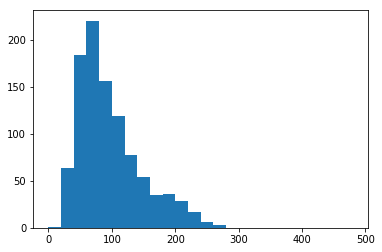

In [32]:
plt.hist(jet_masses(feed_pc), bins=np.arange(0,500,20))
plt.show()

In [42]:
jets = feed_pc
numpoints = len(jets[0])
Delta_Rs = np.linalg.norm(feed_pc,axis=2)
p_parr = np.sum(np.cos(Delta_Rs))
masses = np.sqrt(numpoints**2 - np.power(p_parr,2))*p_norm/numpoints

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [44]:
p_parr

96376.95345754223

In [60]:
np.cos(3.14)

-0.9999987317275395

In [102]:
numload = 1000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
#reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

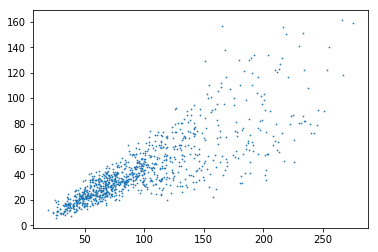

In [34]:
jet_masses(feed_pc[(latent_codes ==0.).flatten()])

array([ 35.28688225,  93.1821818 ,  68.674639  ,  66.82980052,
        74.14441173,  34.51399374,  69.14875579,  36.95418762,
        58.10141722,  35.03645862,  59.17256632,  46.93591623,
        65.7136201 ,  58.5225264 ,  49.73832894,  41.92313558,
        81.62550544,  81.31715223,  61.86501389,  70.09262545,
        55.00411739,  50.09787022,  56.01598295,  41.08508213,
        37.45209645,  26.12286477,  46.64123251,  33.62808724,
        76.62201858,  59.6882946 ,  97.54313234,  61.19816435,
        27.00050637,  52.88769576,  93.3634272 ,  69.40321466,
        32.31190283,  47.50241584,  80.27918911,  80.08367439,
        86.4246068 ,  59.84014424,  73.06503657,  35.90446185,
        70.4502928 ,  52.35135732,  62.28219444,  27.45181723,
        56.91367661,  37.44571713,  43.88163728,  56.53454517,
        91.66736612,  48.45572223,  55.14218424,  26.93894511,
        59.53523344,  90.1539713 ,  43.64649611,  49.89533825,
        65.84580757,  42.11258539,  97.3171227 ,  45.04

In [83]:
latent_codes[latent_codes ==0.][0]

0.0

In [85]:
(latent_codes ==0.)

array([[ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [